In [1]:
"""
!git clone -b EMT https://github.com/pop756/Quantum_KAN.git
%cd Quantum_KAN
!pip install -r requirements.txt"""

Cloning into 'Quantum_KAN'...
remote: Enumerating objects: 795, done.
remote: Counting objects: 100% (795/795), done.
remote: Compressing objects: 100% (740/740), done.
remote: Total 795 (delta 100), reused 736 (delta 52), pack-reused 0
Receiving objects: 100% (795/795), 16.31 MiB | 20.47 MiB/s, done.
Resolving deltas: 100% (100/100), done.
/content/Quantum_KAN
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.9/249.9 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.8/191.8 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

![image.png](attachment:image.png)


사용할것 : 37~43

In [80]:
# Initialize your account
from qiskit_ibm_runtime import QiskitRuntimeService
import qiskit_ibm_provider
from qiskit_aer import AerSimulator
service = QiskitRuntimeService(channel='ibm_quantum',
    instance='ibm-q-skku/skku/skku-students',
    token = '06f802eeac992c43c4106753d7c5fc31414a13eb7d91c99d67fb49cc50569e5b4b011f20c71b9607a07cb43ecc7044557c699022db91d1685ba4c886d5886854')

backend_name = 'ibm_kyiv'
backend_error = service.backend(backend_name)

In [81]:
from qiskit import pulse
from qiskit.pulse.library import Gaussian


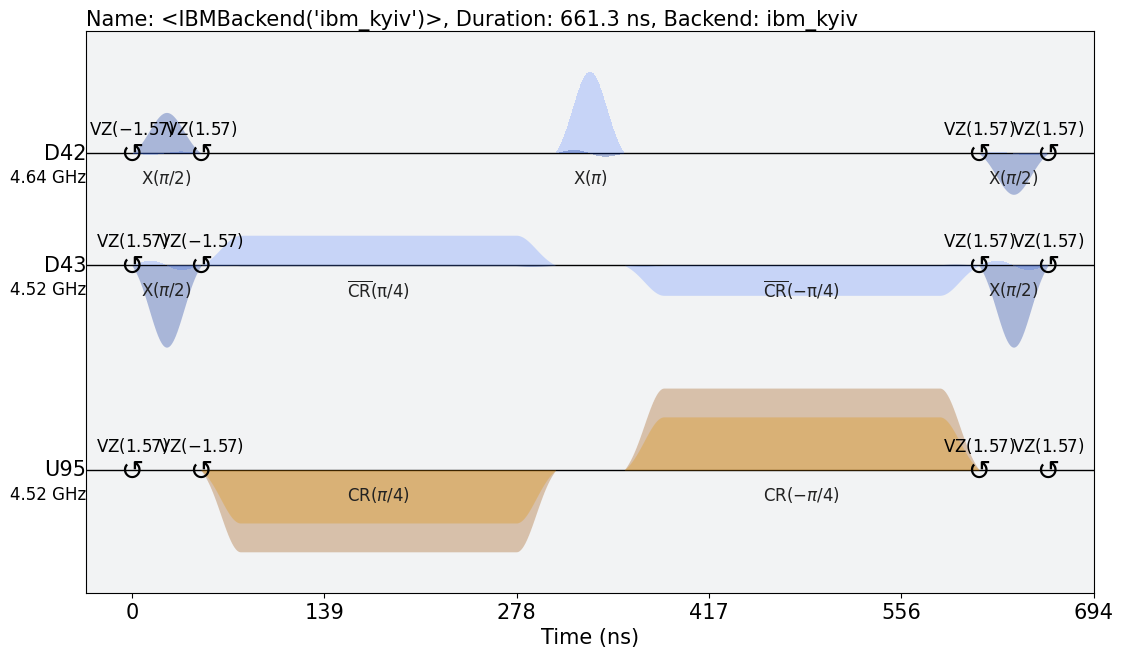

In [82]:
from qiskit import QuantumCircuit
from qiskit import pulse
from qiskit import schedule
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Options
passmanager = generate_preset_pass_manager(optimization_level=0, backend=backend_error, initial_layout=[43, 42])


qubit_use = [37,38,39,40,41,42,43]
circ = QuantumCircuit(2, 2)
circ.ecr(0, 1)
from qiskit import transpile
circ = passmanager.run(circ,backend_error)
pulse_schedule = schedule(circ,backend=backend_error)
pulse_schedule.draw(backend=backend_error)

In [83]:
init_list = []
for item in backend_error.target['ecr']:
    if item[0] in qubit_use and item[1] in qubit_use:
        init_list.append(item)

In [84]:
import copy
from qiskit_ibm_runtime.fake_provider import FakePerth
from qiskit.circuit import QuantumCircuit, Gate
from qiskit.pulse import builder, DriveChannel
from qiskit.transpiler import InstructionProperties
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2,SamplerV2
from qiskit_ibm_runtime import Session
l = 1
init = '11'


error_gate = Gate(f"error", 2, [])
qc1 = QuantumCircuit(2, 2)
if init[0] == '1':
  qc1.x(0)
if init[1] == '1':
  qc1.x(1)
qc1.ecr(0,1)
qc1.ecr(0,1)
qc1.measure(0,0)
qc1.measure(1,1)

def update_ecr(l,init_list,backend):
  layouts = {}
  for initial_layout in init_list:
    custom_gate = Gate(f"error", 2, [])
    pulse_schedule = backend.target['ecr'][initial_layout].calibration
    pulse_copy = copy.deepcopy(pulse_schedule)
    with pulse.build(backend, name=f'err_{initial_layout}') as my_schedule:
        index=0
        for pul in pulse_copy.instructions:
            if index == 0:
              duration = int(round(pul[1].pulse.duration*l/16)*16)
              width = int(pul[1].pulse._params['width']*l)
              x_duration = int(round(pulse_copy.instructions[2][1].pulse.duration/16)*16)
              sigma = int(pul[1].pulse._params['sigma']*l)




            try:
              pul[1].pulse._params['width']
              pul[1].pulse.duration = duration
              pul[1].pulse._params['sigma'] = sigma
              pul[1].pulse._params['width'] = width
              pulse.play(pul[1].pulse,pul[1].channel)
              if index<2:
                pulse.delay(x_duration,pul[1].channel)
              index+=1
            except:
              pass
    layouts[initial_layout] = InstructionProperties(calibration=my_schedule)
    backend.target.update_instruction_properties(f'ecr',initial_layout,properties = InstructionProperties(calibration=my_schedule))
  backend.target.add_instruction(
      custom_gate,
      layouts,
  )


  return my_schedule


my_schedule = update_ecr(l,init_list,backend_error)
initial_layout = init_list[1]
passmanager = generate_preset_pass_manager(optimization_level=0, backend=backend_error, initial_layout=list(initial_layout))
qc1 = passmanager.run(qc1)


In [85]:
import qiskit
from qiskit import QuantumCircuit
import numpy as np
from qiskit.circuit import Parameter
num_qubits=4
J = np.random.uniform(-1, 1, (num_qubits, num_qubits))  # 스핀 간 상호작용 항목
J = np.triu(J, 1)  # 대칭 행렬로 만듦
passmanager = generate_preset_pass_manager(optimization_level=0, backend=backend_error, initial_layout=[37,38,39,40])
def create_trotterized_ising_model_circuit(num_qubits, trotter_steps, time):
    """
    Trotterization을 사용하여 Ising 모델의 양자 서킷을 생성합니다.
    각 Rz 게이트의 파라미터는 Qiskit Parameter로 동적으로 설정됩니다.

    Parameters:
    - num_qubits: 큐비트의 수
    - trotter_steps: Trotterization 단계 수
    - time: 진화 시간

    Returns:
    - QuantumCircuit: 생성된 양자 서킷
    - dict: 서킷 파라미터 사전
    """
    qc = QuantumCircuit(num_qubits)
    delta_t = time / trotter_steps

    # 파라미터 설정
    h_params = [Parameter(f'h_{i}') for i in range(num_qubits)]
    J_params = [[Parameter(f'J_{i}_{j}') for j in range(num_qubits)] for i in range(num_qubits)]

    for _ in range(trotter_steps):
        # 자기 상호작용 항목 추가
        for i in range(num_qubits):
            qc.rx(2 * h_params[i] * delta_t, i)

        # 스핀 간 상호작용 항목 추가
        for i in range(num_qubits):
            for j in range(i + 1, num_qubits):
                if J_params[i][j] != 0:
                    qc.cx(i, j)
                    qc.rz(2 * J_params[i][j] * delta_t, j)
                    qc.cx(i, j)

    return qc, h_params, J_params

# 파라미터 설정
h = np.random.uniform(-1, 1, num_qubits)  # 자기 상호작용 항목

# Trotterization을 사용한 Ising 모델 서킷 생성
trotterized_ising_circuit,_,_ = create_trotterized_ising_model_circuit(4,2,1)
trotterized_ising_circuit.draw('mpl')
qc_input = passmanager.run(trotterized_ising_circuit)

In [86]:
len(qc_input.parameters)

10

In [89]:
from qiskit.quantum_info import SparsePauliOp
"""
qc_list = []
for i in range(20):
    qc1 = QuantumCircuit(2, 2)
    if init[0] == '1':
        qc1.x(0)
    if init[1] == '1':
        qc1.x(1)
    #qc1.ecr(0,1)
    #qc1.ecr(0,1)
    for j in range(i):
        qc1.ecr(0,1)
        qc1.ecr(0,1)
    qc1.measure(0,0)
    qc1.measure(1,1)
    qc1 = passmanager.run(qc1)
    qc_list.append(qc1)"""
np.random.seed(30)
theta = np.random.uniform(-3.14, 3.14, [100,10])
hamiltonian = SparsePauliOp.from_list([("ZIII", 1), ("IZII", 1), ("IIZI", 1),("IIIZ", 1)])
isa_observables = hamiltonian.apply_layout(qc_input.layout)

with Session(backend=backend_error) as session:
  estimator = EstimatorV2(backend=backend_error)
  estimator.resilience_level = 1
  job = estimator.run([(qc_input, isa_observables, theta[i]) for i in range(100)])
  #job = sampler.run(qc_list,shots=8000)
  job.update_tags([f"l={l}"])

In [72]:
np.random.seed(30)
np.random.uniform(-3.14, 3.14, 10)

array([ 0.90522141, -0.74889949,  1.02394085, -2.11227344,  2.90517707,
       -0.96296364,  3.08819623, -1.66383642,  0.53816001, -0.58598616])

In [77]:
np.random.uniform(-3.14, 3.14, [100,10])[0]

array([ 0.06802509,  0.48169707, -0.71966083, -3.01181677,  1.33082806,
       -0.52783312, -2.83191271,  0.7900798 , -0.95430439,  0.21396523])

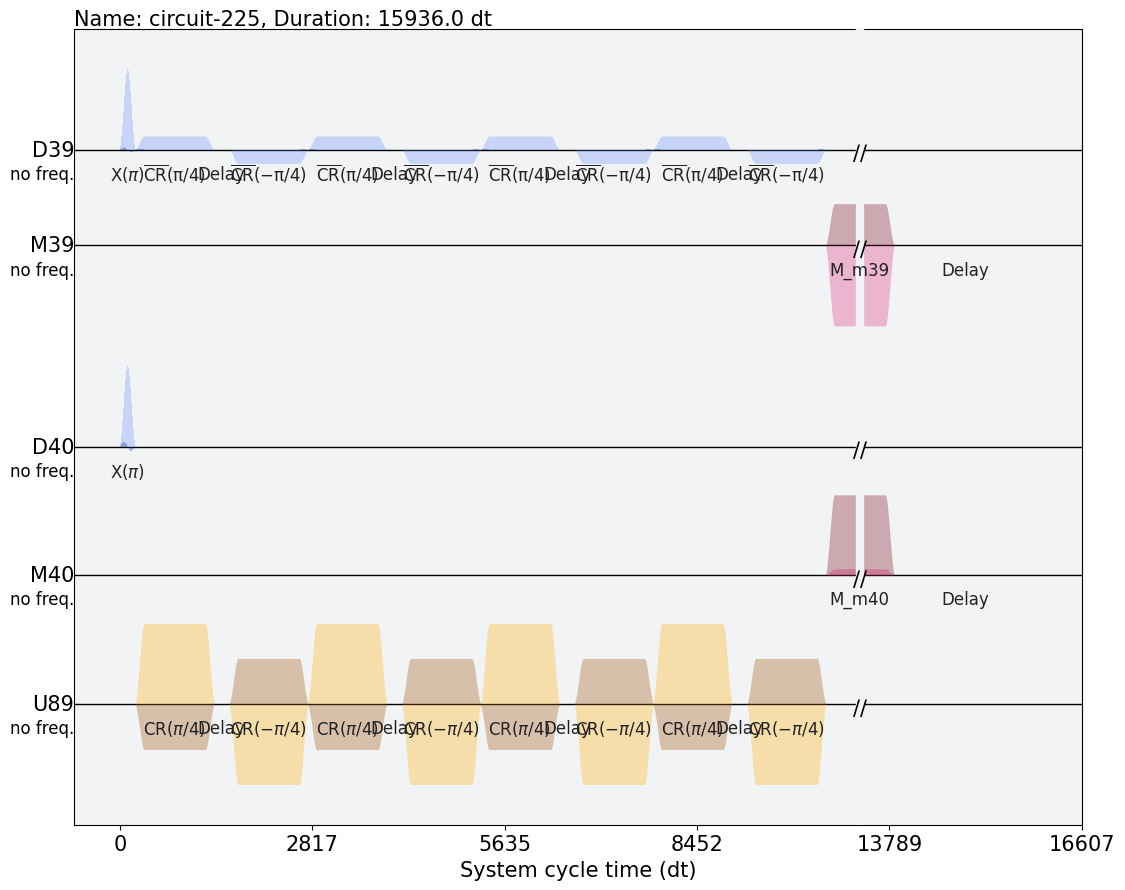

In [28]:
schedule(qc_list[2],backend=backend_error).draw()

In [ ]:
service = QiskitRuntimeService(channel='ibm_quantum',
    instance='ibm-q-skku/skku/skku-students',
    token = '06f802eeac992c43c4106753d7c5fc31414a13eb7d91c99d67fb49cc50569e5b4b011f20c71b9607a07cb43ecc7044557c699022db91d1685ba4c886d5886854')


backend = service.backend(backend_name)

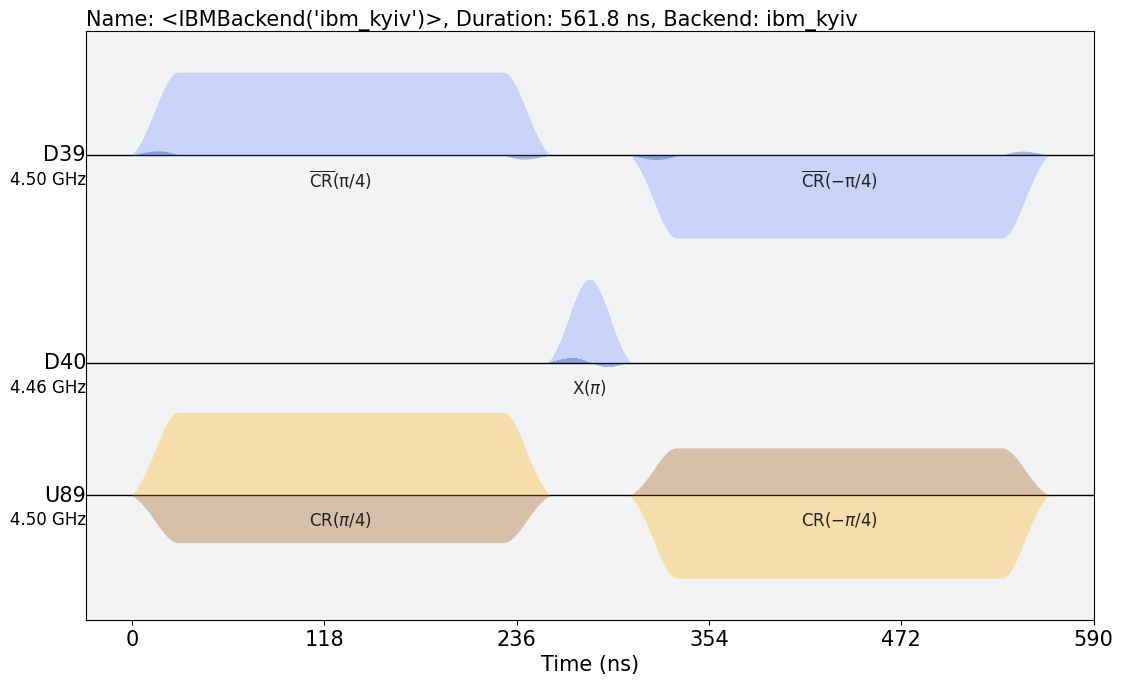

In [ ]:
passmanager = generate_preset_pass_manager(optimization_level=0, backend=backend, initial_layout=list(initial_layout))


qubit_use = [37,38,39,40,41,42,43]
circ = QuantumCircuit(2, 2)
circ.ecr(0, 1)
from qiskit import transpile
circ = passmanager.run(circ,backend)
pulse_schedule = schedule(circ,backend=backend)
pulse_schedule.draw(backend=backend)

In [ ]:
qc_parameter = trotterized_ising_circuit

In [ ]:
qc_list = []
for i in range(20):
    qc1 = QuantumCircuit(2, 2)
    if init[0] == '1':
        qc1.x(0)
    if init[1] == '1':
        qc1.x(1)
    #qc1.ecr(0,1)
    #qc1.ecr(0,1)
    for j in range(i):
        qc1.ecr(0,1)
        qc1.ecr(0,1)
    qc1.measure(0,0)
    qc1.measure(1,1)
    qc1 = passmanager.run(qc1)
    qc_list.append(qc1)

with Session(backend=backend,session_id='train') as session:
  sampler = SamplerV2(backend=backend)
  job = sampler.run(qc_list,shots=8000)
  job.update_tags(["ecr",init,str(initial_layout)])

['(40, 39)', '11', 'ecr']

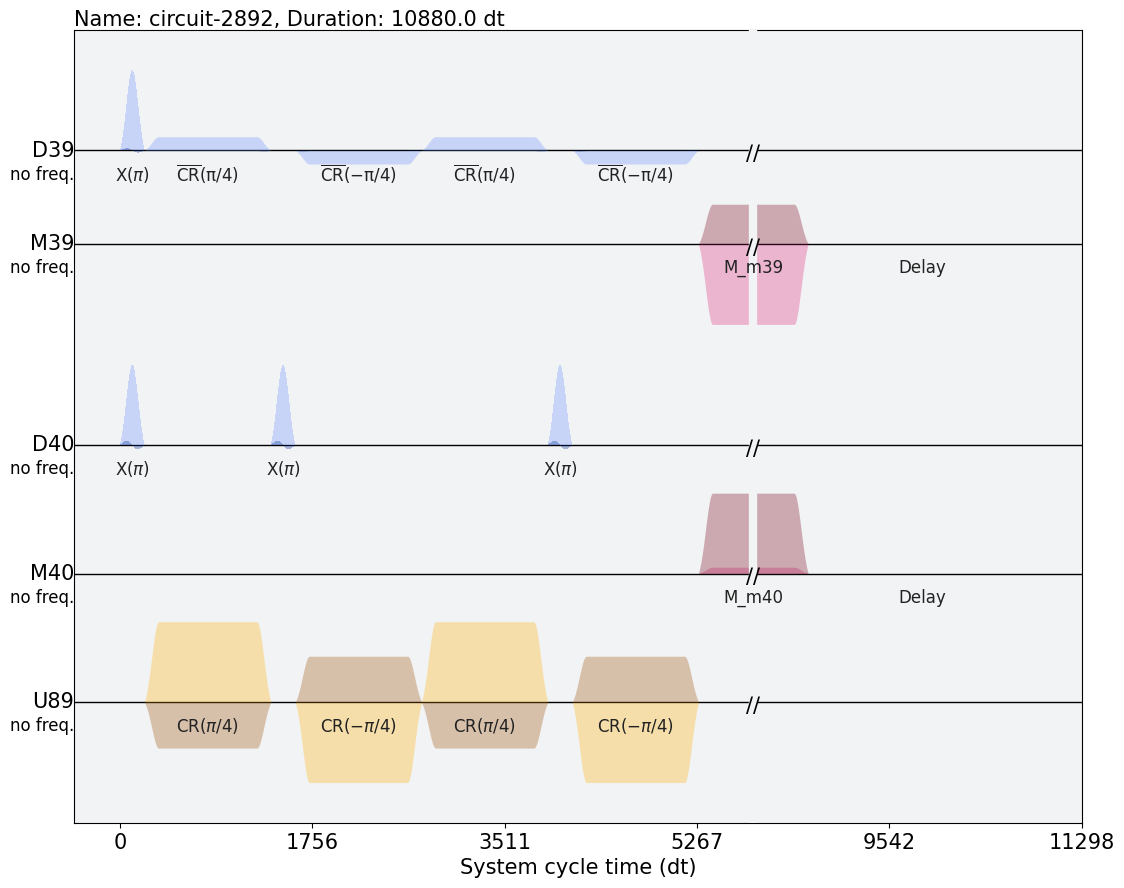

In [ ]:
schedule(qc_list[0],backend=backend).draw()

In [ ]:
import pennylane as qml
from pennylane import numpy as np



# 2 큐빗 양자 회로를 시뮬레이션할 디바이스 설정

dev = qml.device('default.qubit', wires=2)


# 양자 회로 정의
@qml.qnode(dev)
def circuit():

    qml.ECR(wires=[1, 0])

    return qml.expval(qml.PauliY(0)+qml.PauliZ(1))

# 회로 실행 및 기댓값 출력
expectation_value = circuit()
print(f"Expectation value: {expectation_value}")


Expectation value: -1.9999999999999993


In [ ]:
jobs = service.jobs()

In [ ]:
for job in jobs[:2]:
    job.inputs['circuits'][3].draw(idle_wires=False)

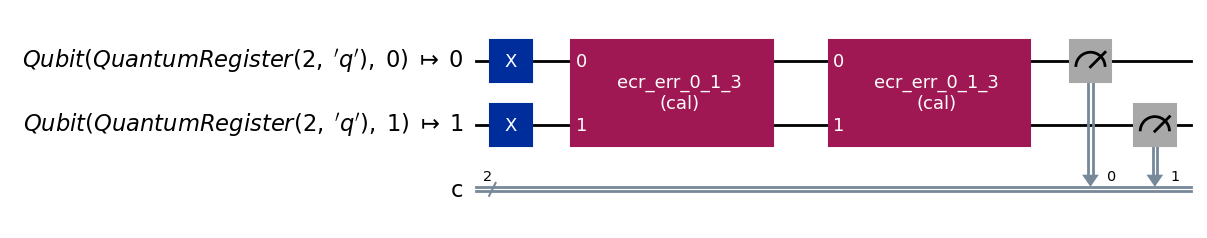

In [ ]:
job.inputs['circuits'][1].draw('mpl',idle_wires=False)